# Do interface design on the best docks

### Boilerplate

In [1]:
%load_ext lab_black
# python internal
import collections
import copy
import gc
from glob import glob
import h5py
import itertools
import os
import random
import re
import socket
import shutil
import subprocess
import sys

# conda/pip
import dask
import graphviz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
from tqdm import tqdm

# special packages on the DIGS
import py3Dmol
import pymol
import pyrosetta

# notebook magic
%matplotlib inline
%load_ext autoreload
%autoreload 2

print(os.getcwd())
print(socket.gethostname())

/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders
dig80


### Make a function to do one sided PPI design
use `tutorial_design_v5.xml` as an example
added CYS/CYD restriction  
try `<Index name="" resnums="{}" />` instead of slices             

In [5]:
from pyrosetta.distributed.packed_pose.core import PackedPose
from pyrosetta.distributed import requires_init


@requires_init
def almost_intdes(packed_pose_in: PackedPose, **kwargs) -> PackedPose:
    """
    Wrap a pyrosetta compatible version of @bcov interface design v5 xml.
    Save scores to pose
    """
    import bz2
    import pyrosetta
    from pyrosetta.rosetta.core.pose import Pose
    import pyrosetta.distributed.io as io
    from pyrosetta.distributed.tasks.rosetta_scripts import (
        SingleoutputRosettaScriptsTask,
    )

    if packed_pose_in == None:
        file = kwargs["-s"]
        with open(file, "rb") as f:
            packed_pose_in = io.pose_from_pdbstring(bz2.decompress(f.read()).decode())
        scores = dict(pyrosetta.distributed.cluster.get_scores_dict(file)["scores"])
    else:
        raise RuntimeError("Need to supply an input")

    if "sasa_threshold" in kwargs.keys():
        sasa_threshold = kwargs["sasa_threshold"]
    else:
        sasa_threshold = 1350

    xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
            <ScoreFunction name="sfxn" weights="beta_nov16" />
            <ScoreFunction name="sfxn_soft" weights="beta_nov16_soft" />
            <ScoreFunction name="sfxn_fa_atr" weights="empty" >
                <Reweight scoretype="fa_atr" weight="1" />
            </ScoreFunction>
            <ScoreFunction name="sfxn_relax" weights="beta_nov16" >
                <Reweight scoretype="arg_cation_pi" weight="3" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="5" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-0.5" />
            </ScoreFunction>
            <ScoreFunction name="sfxn_design" weights="beta_nov16" >
                <Reweight scoretype="res_type_constraint" weight="1.5" />
                <Reweight scoretype="aa_composition" weight="1.0" />
                <Reweight scoretype="arg_cation_pi" weight="3" />
                <Reweight scoretype="approximate_buried_unsat_penalty" weight="5" />
                <Set approximate_buried_unsat_penalty_burial_atomic_depth="3.5" />
                <Set approximate_buried_unsat_penalty_hbond_energy_threshold="-0.5" />
                <Set approximate_buried_unsat_penalty_hbond_bonus_cross_chain="-1" />
            </ScoreFunction>
            <ScoreFunction name="vdw_sol" weights="empty" >
                <Reweight scoretype="fa_atr" weight="1.0" />
                <Reweight scoretype="fa_rep" weight="0.55" />
                <Reweight scoretype="fa_sol" weight="1.0" />
            </ScoreFunction>
        </SCOREFXNS>
        <TASKOPERATIONS>
            <SelectBySASA name="PR_monomer_core_sel" mode="sc" state="monomer" probe_radius="2.2" core_asa="15" surface_asa="15" core="0" boundary="1" surface="1" verbose="0" />
        </TASKOPERATIONS>
        <RESIDUE_SELECTORS>
            <Chain name="chainA" chains="A"/>
            <Chain name="chainB" chains="B"/>
            <Neighborhood name="interface_chA" selector="chainB" distance="10.0" />
            <Neighborhood name="interface_chB" selector="chainA" distance="10.0" />
            <And name="AB_interface" selectors="interface_chA,interface_chB" />
            <Not name="Not_interface" selector="AB_interface" />
            <And name="actual_interface_chA" selectors="AB_interface,chainA" />
            <And name="actual_interface_chB" selectors="AB_interface,chainB" />
            <And name="chainB_not_interface" selectors="Not_interface,chainB" />
            <Not name="not_chB" selector="chainB" />

            <ResidueName name="pro_and_gly_positions" residue_name3="PRO,GLY,CYS,CYD" />
            <ResidueName name="apolar" residue_name3="ALA,CYS,PHE,ILE,LEU,MET,THR,PRO,VAL,TRP,TYR" />
            <Not name="polar" selector="apolar" />

            <InterfaceByVector name="interface_by_vector" cb_dist_cut="11" nearby_atom_cut="5.5" vector_angle_cut="75" vector_dist_cut="9" grp1_selector="actual_interface_chA" grp2_selector="actual_interface_chB"/>
            <Task name="all_cores" fixed="true" task_operations="PR_monomer_core_sel" packable="false" designable="false"/>
            <And name="for_hydrophobic" selectors="actual_interface_chA,interface_by_vector">
                <Not selector="all_cores" />
            </And>

            <ResiduePDBInfoHasLabel name="HOTSPOT_res" property="HOTSPOT" />
            <ResiduePDBInfoHasLabel name="DONE_res" property="DONE" />
            
            <Index name="res1" resnums="1" />
            <Index name="patchdock_res" resnums="{interface_hydrophobics}" />

            <Index name="pocket" resnums="{interface_hydrophobics}" />
            <And name="target_not_pocket" selectors="chainB">
                <Not selector="pocket" />
            </And>

            <Layer name="surface" select_core="false" select_boundary="false" select_surface="true" use_sidechain_neighbors="true"/>
            <Layer name="boundary" select_core="false" select_boundary="true" select_surface="false" use_sidechain_neighbors="true"/>
            <Layer name="core" select_core="true" select_boundary="false" select_surface="false" use_sidechain_neighbors="true"/>
            <SecondaryStructure name="sheet" overlap="0" minH="3" minE="2" include_terminal_loops="false" use_dssp="true" ss="E"/>
            <SecondaryStructure name="entire_loop" overlap="0" minH="3" minE="2" include_terminal_loops="true" use_dssp="true" ss="L"/>
            <SecondaryStructure name="entire_helix" overlap="0" minH="3" minE="2" include_terminal_loops="false" use_dssp="true" ss="H"/>
            <And name="helix_cap" selectors="entire_loop">
                <PrimarySequenceNeighborhood lower="1" upper="0" selector="entire_helix"/>
            </And>
            <And name="helix_start" selectors="entire_helix">
                <PrimarySequenceNeighborhood lower="0" upper="1" selector="helix_cap"/>
            </And>
            <And name="helix" selectors="entire_helix">
                <Not selector="helix_start"/>
            </And>
            <And name="loop" selectors="entire_loop">
                <Not selector="helix_cap"/>
            </And>

        </RESIDUE_SELECTORS>
        <TASKOPERATIONS>
            <DesignRestrictions name="layer_design_F_boundary_M">
                <Action selector_logic="not_chB AND surface AND helix_start"  aas="DEHKPQR"/>
                <Action selector_logic="not_chB AND surface AND helix"        aas="EHKQR"/>
                <Action selector_logic="not_chB AND surface AND sheet"        aas="EHKNQRST"/>
                <Action selector_logic="not_chB AND surface AND loop"         aas="DEGHKNPQRST"/>
                <Action selector_logic="not_chB AND boundary AND helix_start" aas="ADEFHIKLMNPQRSTVWY"/>
                <Action selector_logic="not_chB AND boundary AND helix"       aas="ADEFHIKLMNQRSTVWY"/>
                <Action selector_logic="not_chB AND boundary AND sheet"       aas="DEFHIKLMNQRSTVWY"/>
                <Action selector_logic="not_chB AND boundary AND loop"        aas="ADEFGHIKLNPQRSTVWY"/>
                <Action selector_logic="not_chB AND core AND helix_start"     aas="AFILMPVWY"/>
                <Action selector_logic="not_chB AND core AND helix"           aas="AFILMVWYDENQSTH"/>
                <Action selector_logic="not_chB AND core AND sheet"           aas="FILMVWYDENQSTH"/>
                <Action selector_logic="not_chB AND core AND loop"            aas="AFGILPVWYDENQSTH"/>
                <Action selector_logic="not_chB AND helix_cap"                aas="DNST"/>
            </DesignRestrictions>
        </TASKOPERATIONS>
        <MOVERS>
            <AddCompositionConstraintMover name="3trp" >
                <Comp entry="PENALTY_DEFINITION;TYPE TRP;ABSOLUTE 0;PENALTIES 0 3;DELTA_START 0;DELTA_END 1;BEFORE_FUNCTION CONSTANT;AFTER_FUNCTION LINEAR;END_PENALTY_DEFINITION;" />
            </AddCompositionConstraintMover>
            <AddCompositionConstraintMover name="2met" >
                <Comp entry="PENALTY_DEFINITION;TYPE MET;ABSOLUTE 0;PENALTIES 0 2;DELTA_START 0;DELTA_END 1;BEFORE_FUNCTION CONSTANT;AFTER_FUNCTION LINEAR;END_PENALTY_DEFINITION;" />
            </AddCompositionConstraintMover>
            <AddCompositionConstraintMover name="30_percent_polar" selector="for_hydrophobic">
                <Comp entry="PENALTY_DEFINITION;TYPE ASP GLU HIS LYS ASN GLN ARG SER THR TYR;FRACT_DELTA_START -0.01;FRACT_DELTA_END 0.0;PENALTIES 0.1 0 ;FRACTION 0.30;BEFORE_FUNCTION QUADRATIC;AFTER_FUNCTION CONSTANT;END_PENALTY_DEFINITION" />
            </AddCompositionConstraintMover>
        </MOVERS>
        <TASKOPERATIONS>
            <PruneBuriedUnsats name="prune_buried_unsats" allow_even_trades="false" atomic_depth_cutoff="3.5" minimum_hbond_energy="-0.5" />
            <ProteinProteinInterfaceUpweighter name="upweight_interface" interface_weight="3" />
            <ProteinInterfaceDesign name="pack_long" design_chain1="0" design_chain2="0" jump="1" interface_distance_cutoff="15"/>
            <IncludeCurrent name="current" />
            <LimitAromaChi2 name="limitchi2" chi2max="110" chi2min="70" include_trp="True" />
            <ExtraRotamersGeneric name="ex1_ex2" ex1="1" ex2aro="1" />

            <OperateOnResidueSubset name="restrict_target_not_interface" selector="chainB_not_interface">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="restrict_to_interface" selector="Not_interface">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="restrict_target2repacking" selector="chainB">
                <RestrictToRepackingRLT/>
            </OperateOnResidueSubset>
            <OperateOnResidueSubset name="restrict_hotspots2repacking" selector="HOTSPOT_res">
                <RestrictToRepackingRLT/>
            </OperateOnResidueSubset>
            <DisallowIfNonnative name="disallow_GLY" resnum="0" disallow_aas="G" />
            <DisallowIfNonnative name="disallow_PRO" resnum="0" disallow_aas="P" />
            <OperateOnResidueSubset name="restrict_PRO_GLY" selector="pro_and_gly_positions">
                <PreventRepackingRLT/>
            </OperateOnResidueSubset>

            <SelectBySASA name="PR_monomer_core" mode="sc" state="monomer" probe_radius="2.2" core_asa="10" surface_asa="10" core="0" boundary="1" surface="1" verbose="0" />

        </TASKOPERATIONS>
        <RESIDUE_SELECTORS>
            <And name="sheetA" selectors="sheet,chainA" />
        </RESIDUE_SELECTORS>
        <MOVERS>

            <DeleteRegionMover name="delete_target_not_pocket" residue_selector="target_not_pocket" rechain="false" />

            <SwitchChainOrder name="chain1onlypre" chain_order="1" />
            <ScoreMover name="scorepose" scorefxn="sfxn" verbose="false" />
            <ParsedProtocol name="chain1only">
                <Add mover="chain1onlypre" />
                <Add mover="scorepose" />
            </ParsedProtocol>
            <TaskAwareMinMover name="min" scorefxn="sfxn" bb="0" chi="1" task_operations="pack_long" />

            <DeleteRegionMover name="delete_polar" residue_selector="polar" rechain="false" />

            <FastRelax name="relax_chain1" scorefxn="sfxn" repeats="1" batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" bondlength="false" min_type="dfpmin_armijo_nonmonotone" task_operations="ex1_ex2,limitchi2" >
                <MoveMap name="MM" >
                    <Chain number="1" chi="true" bb="true" />
                </MoveMap>
            </FastRelax>

            <ParsedProtocol name="chain1only_relax">
                <Add mover="chain1onlypre" />
                <Add mover="relax_chain1" />
            </ParsedProtocol>

            <StructProfileMover name="genProfile" add_csts_to_pose="1" consider_topN_frags="100" eliminate_background="0" ignore_terminal_residue="1" only_loops="0" burialWt="0" RMSthreshold="0.6" residue_selector="chainA" />

            <ClearConstraintsMover name="clear_constraints" />

            <SavePoseMover name="save_output" restore_pose="0" reference_name="pose_output" />
            <SavePoseMover name="load_output" restore_pose="1" reference_name="pose_output" />

            <LabelPoseFromResidueSelectorMover name="remove_done" remove_property="DONE"  residue_selector="res1" />
            <LabelPoseFromResidueSelectorMover name="add_done" property="DONE" residue_selector="res1" />

        </MOVERS>
        <FILTERS>
            <Sasa name="interface_buried_sasa" confidence="0" />
            <Sasa name="gate_filter" threshold="{sasa_threshold}" confidence="1" />
            <Ddg name="ddg"  threshold="-10" jump="1" repeats="5" repack="1" relax_mover="min" confidence="0" scorefxn="sfxn" extreme_value_removal="1" />

            <ShapeComplementarity name="interface_sc" verbose="0" min_sc="0.55" write_int_area="1" write_median_dist="1" jump="1" confidence="0"/>
            <ShapeComplementarity name="interface_sc_for_fr1" verbose="0" min_sc="0.55" write_int_area="1" write_median_dist="1" jump="1" confidence="0"/>

            <ScoreType name="total_score_MBF" scorefxn="sfxn" score_type="total_score" threshold="0" confidence="0" />
            <MoveBeforeFilter name="total_score_monomer" mover="chain1only" filter="total_score_MBF" confidence="0" />
            <ResidueCount name="res_count_MBF" max_residue_count="9999" confidence="0"/>
            <MoveBeforeFilter name="res_count_monomer" mover="chain1only" filter="res_count_MBF" confidence="0" />

            <CalculatorFilter name="score_per_res" equation="total_score_monomer / res" threshold="-3.5" confidence="0">
                <Var name="total_score_monomer" filter="total_score_monomer"/>
                <Var name="res" filter="res_count_monomer"/>
            </CalculatorFilter>

            <MoveBeforeFilter name="total_score_relax_monomer" mover="chain1only_relax" filter="total_score_MBF" confidence="0" />

            <CalculatorFilter name="score_per_res_relax" equation="total_score_relax_monomer / res" threshold="-3.5" confidence="0">
                <Var name="total_score_relax_monomer" filter="total_score_relax_monomer"/>
                <Var name="res" filter="res_count_monomer"/>
            </CalculatorFilter>

            <BuriedUnsatHbonds name="buns_heavy_ball_1.1D" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" scorefxn="sfxn" residue_selector="AB_interface" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" use_ddG_style="true" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1" max_hbond_energy="1.5" burial_cutoff_apo="0.2" />
            <BuriedUnsatHbonds name="sbuns5.0_heavy_ball_1.1D" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" scorefxn="sfxn" residue_selector="AB_interface" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" use_ddG_style="true" burial_cutoff="0.01" dalphaball_sasa="true" probe_radius="1.1" atomic_depth_selection="5.0" atomic_depth_deeper_than="false" burial_cutoff_apo="0.2" atomic_depth_resolution="0.49" max_hbond_energy="1.5"/>

            <BuriedUnsatHbonds name="vbuns5.0_heavy_ball_1.1D" use_reporter_behavior="true" report_all_heavy_atom_unsats="true" scorefxn="sfxn" residue_selector="AB_interface" ignore_surface_res="false" print_out_info_to_pdb="true" confidence="0" use_ddG_style="true" dalphaball_sasa="true" probe_radius="1.1" atomic_depth_selection="5.0" burial_cutoff="1000" burial_cutoff_apo="0.2" atomic_depth_apo_surface="5.5" atomic_depth_resolution="0.49" max_hbond_energy="1.5"/>

            <InterfaceHydrophobicResidueContacts name="hydrophobic_residue_contacts" target_selector="chainB" binder_selector="chainA" scorefxn="sfxn_soft" confidence="0"/> 
            <ContactMolecularSurface name="contact_molecular_surface" distance_weight="0.5" target_selector="chainA" binder_selector="chainB" confidence="0" />
            <ContactMolecularSurface name="contact_patch" distance_weight="0.5" target_selector="patchdock_res" binder_selector="chainA" confidence="0" />

            <Ddg name="ddg_hydrophobic_pre"  threshold="-10" jump="1" repeats="1" repack="0" confidence="0" scorefxn="vdw_sol" />
            <MoveBeforeFilter name="ddg_hydrophobic" mover="delete_polar" filter="ddg_hydrophobic_pre" confidence="0"/>

            <Ddg name="fa_atr_pocket_pre"  threshold="-15" jump="1" repeats="1" repack="0" confidence="0" scorefxn="sfxn_fa_atr" />
            <MoveBeforeFilter name="fa_atr_pocket" mover="delete_target_not_pocket" filter="fa_atr_pocket_pre" confidence="0"/>

            <SSPrediction name="pre_sspred_overall" cmd="/software/psipred4/runpsipred_single" use_probability="0" use_svm="0" threshold="0.85" confidence="0" />
            <MoveBeforeFilter name="sspred_overall" mover="chain1only" filter="pre_sspred_overall" confidence="0" />

            <SSPrediction name="pre_mismatch_probability" confidence="0" cmd="/software/psipred4/runpsipred_single" use_probability="1" mismatch_probability="1" use_svm="0" />
            <MoveBeforeFilter name="mismatch_probability" mover="chain1only" filter="pre_mismatch_probability" confidence="0" />

            <ScorePoseSegmentFromResidueSelectorFilter name="has_sheet" in_context="1" residue_selector="sheetA" scorefxn="sfxn" confidence="0" />
            <ScorePoseSegmentFromResidueSelectorFilter name="was_done" in_context="1" residue_selector="DONE_res" scorefxn="sfxn" confidence="0" />

            <SSShapeComplementarity name="ss_sc_pre" verbose="0" confidence="0" />
            <MoveBeforeFilter name="ss_sc" mover="chain1only" filter="ss_sc_pre" confidence="0"/>

            <Time name="timed"/>
            <TrueFilter name="my_true_filter" />
        </FILTERS>
        <MOVERS>
            <FastDesign name="FastDesign" scorefxn="sfxn_design" repeats="1" task_operations="current,limitchi2,ex1_ex2,restrict_to_interface,restrict_target2repacking,restrict_hotspots2repacking,disallow_GLY,disallow_PRO,PR_monomer_core,upweight_interface,restrict_PRO_GLY,prune_buried_unsats,layer_design_F_boundary_M" batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" bondlength="false" min_type="dfpmin_armijo_nonmonotone" relaxscript="InterfaceDesign2019" >
                <MoveMap name="MM" >
                        <Chain number="1" chi="true" bb="true" />
                        <Chain number="2" chi="true" bb="false" />
                        <Jump number="1" setting="true" />
                </MoveMap>
            </FastDesign>
            <FastRelax name="FastRelax" scorefxn="sfxn_relax" repeats="1" batch="false" ramp_down_constraints="false" cartesian="false" bondangle="false" bondlength="false" min_type="dfpmin_armijo_nonmonotone" task_operations="current,ex1_ex2,restrict_target_not_interface,limitchi2,prune_buried_unsats" >
                <MoveMap name="MM" >
                    <Chain number="1" chi="true" bb="true" />
                    <Chain number="2" chi="true" bb="false" />
                    <Jump number="1" setting="true" />
                </MoveMap>
            </FastRelax>
            <ParsedProtocol name="go_go_go" mode="sequence">
                <Add filter="gate_filter" />
                Add mover="genProfile" />
                <Add mover="3trp" />
                <Add mover="2met" />
                <Add mover="30_percent_polar" />
                <Add mover="FastDesign" />
                <Add mover="save_output" />
                <Add mover="FastDesign" />
                <Add mover="clear_constraints" />
                <Add mover="FastRelax" />
                <Add mover="add_done" />
                <Add mover="save_output" />
            </ParsedProtocol>
            <GenericMonteCarlo name="try_go_go_go" mover_name="go_go_go" filter_name="my_true_filter" trials="1" />
        </MOVERS>
        <APPLY_TO_POSE>
        </APPLY_TO_POSE>
        <PROTOCOLS>
            <Add filter="timed" />
            <Add mover="remove_done" />
            <Add mover="save_output" />
            <Add mover="try_go_go_go" />
            <Add mover="load_output" />
            <Add filter_name="interface_buried_sasa" />   
            <Add filter_name="ddg" />                     
            <Add filter="ddg_hydrophobic" />              
            <Add filter_name="interface_sc" />            
            <Add filter_name="score_per_res" />          
            Add filter_name="score_per_res_relax" />    
            <Add filter="vbuns5.0_heavy_ball_1.1D" />    
            <Add filter="sbuns5.0_heavy_ball_1.1D" />    
            <Add filter="buns_heavy_ball_1.1D" />    
            <Add filter="hydrophobic_residue_contacts" />
            <Add filter="fa_atr_pocket" />               
            Add filter="mismatch_probability" />        
            Add filter="sspred_overall" />              
            <Add filter="contact_molecular_surface" />
            <Add filter="contact_patch" />   
            <Add filter="ss_sc" />   
            <Add filter="has_sheet" />
            <Add filter="was_done" />
            <Add filter="timed" />
        </PROTOCOLS>
        <OUTPUT />
    </ROSETTASCRIPTS>
    """.format(
        interface_hydrophobics=scores["interface_hydrophobics"],
        sasa_threshold=sasa_threshold,
    )
    intdes = SingleoutputRosettaScriptsTask(xml)
    designed_ppose = intdes(packed_pose_in.pose.clone())
    new_scores = dict(designed_ppose.pose.scores)
    scores.update(new_scores)
    score_xml = """
    <ROSETTASCRIPTS>
        <SCOREFXNS>
                <ScoreFunction name="sfxn" weights="beta_nov16" />
        </SCOREFXNS>
        <MOVERS>
            <SwitchChainOrder name="chain1only" chain_order="1" />
            <RollMover name="move_chainA_far_away" chain="1" min_angle="0" max_angle="0" axis="x" >
                <translate x="1000" y="1000" z="1000" /> 
            </RollMover>
        </MOVERS>
        <RESIDUE_SELECTORS>
            <Chain name="chainA" chains="A"/>
            <Chain name="chainB" chains="B"/>
            <Neighborhood name="interface_chA" selector="chainB" distance="10.0" />
            <Neighborhood name="interface_chB" selector="chainA" distance="10.0" />
            <And name="AB_interface" selectors="interface_chA,interface_chB" />
            <Not name="Not_interface" selector="AB_interface" />
            <And name="actual_interface_chA" selectors="AB_interface,chainA" />
            <And name="actual_interface_chB" selectors="AB_interface,chainB" />
            <ResidueName name="apolar" residue_name3="ALA,CYS,PHE,ILE,LEU,MET,THR,PRO,VAL,TRP,TYR" />
            <And name="apolar_A" selectors="apolar,actual_interface_chA" />
            <And name="apolar_B" selectors="apolar,actual_interface_chB" />
            <Index name="patchdock_res" resnums="{interface_hydrophobics}" />
            <True name="true_sel" />
        </RESIDUE_SELECTORS>
        <SIMPLE_METRICS>
            <SapScoreMetric name="sap_score" score_selector="chainA" />
            <SapScoreMetric name="sap_score_target" score_selector="chainB" />
            <SapScoreMetric name="binder_blocked_sap" score_selector="chainA" sap_calculate_selector="chainA" sasa_selector="true_sel" />
            <SapScoreMetric name="target_blocked_sap" score_selector="chainB" sap_calculate_selector="chainB" sasa_selector="true_sel" />
        </SIMPLE_METRICS>
        <TASKOPERATIONS>
            <ProteinInterfaceDesign name="pack_long" design_chain1="0" design_chain2="0" jump="1" interface_distance_cutoff="15"/>
        </TASKOPERATIONS>
        <MOVERS>
            <TaskAwareMinMover name="min" scorefxn="sfxn" bb="0" chi="1" task_operations="pack_long" />
        </MOVERS>
        <FILTERS>
            <ContactMolecularSurface name="contact_patch" distance_weight="0.5" target_selector="patchdock_res" binder_selector="chainA" confidence="0" />
            <Ddg name="ddg"  threshold="-10" jump="1" repeats="5" repack="1" relax_mover="min" confidence="0" scorefxn="sfxn" extreme_value_removal="1" />
            <ResidueCount name="res_count_all" max_residue_count="9999" confidence="0"/>
            <BuriedSurfaceArea name="buried_npsa_FAMILYVW" select_only_FAMILYVW="True" atom_mode="hydrophobic_atoms" confidence="0.0" />
            <BuriedSurfaceArea name="buried_npsa" select_only_FAMILYVW="False" atom_mode="hydrophobic_atoms" confidence="0.0" />
            <ExposedHydrophobics name="exposed_hydrophobics"  confidence="0" />
            <CalculatorFilter name="buried_npsa_per_res" equation="total_score / res" threshold="-3.2" confidence="0">
                <Var name="total_score" filter="buried_npsa"/>
                <Var name="res" filter="res_count_all"/>
            </CalculatorFilter>
            <CalculatorFilter name="buried_npsa_FAMILYVW_per_res" equation="total_score / res" threshold="-3.2" confidence="0">
                <Var name="total_score" filter="buried_npsa_FAMILYVW"/>
                <Var name="res" filter="res_count_all"/>
            </CalculatorFilter>
            <MoveBeforeFilter name="buried_npsa_FAMILYVW_monomer" mover="chain1only" filter="buried_npsa_FAMILYVW" confidence="0" />
            <MoveBeforeFilter name="buried_npsa_monomer" mover="chain1only" filter="buried_npsa" confidence="0" />
            <MoveBeforeFilter name="exposed_hydrophobics_monomer" mover="chain1only" filter="exposed_hydrophobics" confidence="0" />
            <MoveBeforeFilter name="buried_npsa_per_res_monomer" mover="chain1only" filter="buried_npsa_per_res" confidence="0" />
            <MoveBeforeFilter name="buried_npsa_FAMILYVW_per_res_monomer" mover="chain1only" filter="buried_npsa_FAMILYVW_per_res" confidence="0" />
            <MoveBeforeFilter name="buried_npsa_FAMILYVW_apo" mover="move_chainA_far_away" filter="buried_npsa_FAMILYVW" confidence="0" />
            <MoveBeforeFilter name="buried_npsa_apo" mover="move_chainA_far_away" filter="buried_npsa" confidence="0" />
            <MoveBeforeFilter name="exposed_hydrophobics_apo" mover="move_chainA_far_away" filter="exposed_hydrophobics" confidence="0" />
            <CalculatorFilter   name="delta_buried_npsa_FAMILYVW" equation="complex - apo" threshold="-3.2" confidence="0">
                <Var name="complex" filter="buried_npsa_FAMILYVW"/>
                <Var name="apo"     filter="buried_npsa_FAMILYVW_apo"/>
            </CalculatorFilter>
            <CalculatorFilter   name="delta_buried_npsa" equation="complex - apo" threshold="-3.2" confidence="0">
                <Var name="complex" filter="buried_npsa"/>
                <Var name="apo"     filter="buried_npsa_apo"/>
            </CalculatorFilter>
            <CalculatorFilter   name="delta_exposed_hydrophobics" equation="complex - apo" threshold="-3.2" confidence="0">
                <Var name="complex" filter="exposed_hydrophobics"/>
                <Var name="apo"     filter="exposed_hydrophobics_apo"/>
            </CalculatorFilter>
            <ContactMolecularSurface name="contact_molecular_surface_ap_target" distance_weight="0.5" target_selector="apolar_B" binder_selector="chainA" confidence="0" />
            <ContactMolecularSurface name="contact_molec_sq5_ap_target" distance_weight="0.5" target_selector="apolar_B" binder_selector="chainA" confidence="0" near_squared_size="5" />
            <ContactMolecularSurface name="contact_molecular_surface_apap_target" distance_weight="0.5" target_selector="apolar_B" binder_selector="chainA" confidence="0" apolar_target="true" />
            <ContactMolecularSurface name="contact_molec_sq5_apap_target" distance_weight="0.5" target_selector="apolar_B" binder_selector="chainA" confidence="0" near_squared_size="5" apolar_target="true" />
            <ContactMolecularSurface name="contact_molecular_surface_ap_binder" distance_weight="0.5" target_selector="apolar_A" binder_selector="chainB" confidence="0" />
            <ContactMolecularSurface name="contact_molec_sq5_ap_binder" distance_weight="0.5" target_selector="apolar_A" binder_selector="chainB" confidence="0" near_squared_size="5" />
            <ContactMolecularSurface name="contact_molecular_surface_apap_binder" distance_weight="0.5" target_selector="apolar_A" binder_selector="chainB" confidence="0" apolar_target="true" />
            <ContactMolecularSurface name="contact_molec_sq5_apap_binder" distance_weight="0.5" target_selector="apolar_A" binder_selector="chainB" confidence="0" near_squared_size="5" apolar_target="true" />
            <worst9mer name="pre_wnm_all" rmsd_lookup_threshold="0.4" confidence="0" />
            <worst9mer name="pre_wnm_hlx" rmsd_lookup_threshold="0.4" confidence="0" only_helices="true" />
            <MoveBeforeFilter name="wnm_all" mover="chain1only" filter="pre_wnm_all" confidence="0" />
            <MoveBeforeFilter name="wnm_hlx" mover="chain1only" filter="pre_wnm_hlx" confidence="0" />
        </FILTERS>
        <PROTOCOLS>
            <Add filter="contact_molecular_surface_ap_target" />
            <Add filter="contact_molec_sq5_ap_target" />
            <Add filter="contact_molecular_surface_apap_target" />
            <Add filter="contact_molec_sq5_apap_target" />
            <Add filter="contact_patch"/>
            <Add filter="ddg"/>
            <Add filter="wnm_all"/>
            <Add filter="wnm_hlx"/>
            <Add metrics="sap_score" />
            <Add metrics="sap_score_target" />
            <Add metrics="binder_blocked_sap" />
            <Add metrics="target_blocked_sap" />
        </PROTOCOLS>
        <OUTPUT />
    </ROSETTASCRIPTS>
    """.format(
        interface_hydrophobics=scores["interface_hydrophobics"],
    )
    scorer = SingleoutputRosettaScriptsTask(score_xml)
    scored_ppose = scorer(designed_ppose.pose.clone())
    final_scores = dict(scored_ppose.pose.scores)
    scores.update(final_scores)
    scores["file_in"] = file
    scored_pose = io.to_pose(scored_ppose)
    for key, value in scores.items():
        pyrosetta.rosetta.core.pose.setPoseExtraScore(scored_pose, key, str(value))
    final_ppose = io.to_packed(scored_pose)
    return final_ppose

### We're going to do a huge run here, more than it makes sense to use dask for
Will submit everything to `backfill`
Make `SLURM` array tasks

In [9]:
import os, stat, subprocess


def create_tasks(selected):
    with open(selected, "r") as f:
        for file in f:
            for sasa in 0, 1350:
                tasks = {}
                path = file.rstrip()
                tasks["-s"] = path
                tasks["-sasa_threshold"] = sasa
                yield tasks


def file_len(file):
    """https://stackoverflow.com/questions/845058/how-to-get-line-count-of-a-large-file-cheaply-in-python"""
    with open(file) as f:
        for i, l in enumerate(f):
            pass
    return i + 1


targets = glob(os.path.join(os.getcwd(), "00_thread_targets/*.list"))
target_scale = {target: int(50000 / file_len(target)) for target in targets}
almost_intdes = os.path.join(os.getcwd(), "almost_intdes.py")

jid = "{SLURM_JOB_ID%;*}"
sid = "{SLURM_ARRAY_TASK_ID}p"

for target, scale in target_scale.items():
    basename_noext = target.split("/")[-1].replace(".list", "", 1)
    tasklist = f"01_intdes_tasks_{basename_noext}.cmds"
    run_sh = """#!/usr/bin/env bash \n#SBATCH -J almost_intdes \n#SBATCH -e /mnt/home/pleung/logs/slurm_logs/almost_intdes-%J.err \n#SBATCH -o /mnt/home/pleung/logs/slurm_logs/almost_intdes-%J.out \n#SBATCH -p {queue} \n#SBATCH --mem=4G \n\nJOB_ID=${jid} \nCMD=$(sed -n "${sid}" {tasklist}) \necho "${c}" | bash""".format(
        queue="backfill", jid=jid, sid=sid, tasklist=tasklist, c="{CMD}"
    )
    shell = f"01_intdes_run_{basename_noext}.sh"
    with open(shell, "w+") as f:
        print(run_sh, file=f)
    st = os.stat(shell)
    os.chmod(shell, st.st_mode | stat.S_IEXEC)
    with open(f"01_intdes_tasks_{basename_noext}.cmds", "w+") as f:
        for nstruct in range(0, scale):
            outpath = os.path.join(os.getcwd(), f"01_intdes_runs_{basename_noext}")
            full_outpath = os.path.join(os.getcwd(), outpath, f"{nstruct}")
            for tasks in create_tasks(target):
                args_ = " ".join([" ".join([k, str(v)]) for k, v in tasks.items()])
                cmd = f"mkdir -p {full_outpath}; cd {full_outpath}; {almost_intdes} {args_}"
                print(cmd, file=f)

# Let's go
print("Run the following commands")
for target in targets:
    basename_noext = target.split("/")[-1].replace(".list", "", 1)
    print(
        f"sbatch -a 1-$(cat 01_intdes_tasks_{basename_noext}.cmds | wc -l) 01_intdes_run_{basename_noext}.sh"
    )

Run the following commands
sbatch -a 1-$(cat 01_intdes_tasks_pth.cmds | wc -l) 01_intdes_run_pth.sh
sbatch -a 1-$(cat 01_intdes_tasks_neuropeptideY.cmds | wc -l) 01_intdes_run_neuropeptideY.sh
sbatch -a 1-$(cat 01_intdes_tasks_glp.cmds | wc -l) 01_intdes_run_glp.sh
sbatch -a 1-$(cat 01_intdes_tasks_glucagon.cmds | wc -l) 01_intdes_run_glucagon.sh
sbatch -a 1-$(cat 01_intdes_tasks_apoe.cmds | wc -l) 01_intdes_run_apoe.sh
sbatch -a 1-$(cat 01_intdes_tasks_gip.cmds | wc -l) 01_intdes_run_gip.sh
sbatch -a 1-$(cat 01_intdes_tasks_covstem.cmds | wc -l) 01_intdes_run_covstem.sh


### Now need to retrieve the JSONs containing scores for the interface design runs

In [2]:
%%time
import json

output_paths = glob(os.path.join(os.getcwd(), "01_intdes_runs_*/*/*.json"))

scores = {}

for test in tqdm(output_paths):
    pdb = test.replace("json", "pdb.bz2")
    key = f"{pdb}"
    with open(test, "r") as f:
        values = json.load(f)
    scores[key] = values

100%|██████████| 92904/92904 [01:16<00:00, 1219.41it/s]

CPU times: user 14.3 s, sys: 7.68 s, total: 21.9 s
Wall time: 1min 18s


### Write them back to disk as a single scorefile


In [3]:
%%time
scores_df = pd.DataFrame(scores)
scores_df = scores_df.T
output_path = os.path.join(os.getcwd(), "01_filter")
output_file = os.path.join(output_path, "scores.json")
os.makedirs(output_path, exist_ok=True)
scores_df.to_json(output_file)

CPU times: user 16.4 s, sys: 3.64 s, total: 20 s
Wall time: 21.1 s


In [4]:
output_path = os.path.join(os.getcwd(), "01_filter")
scores = os.path.join(output_path, "scores.json")
scores_df = pd.read_json(scores)
scores_df.head()

,9mer,abego_str,bb_clash,buns_heavy_ball_1.1D,chB_length,chB_start,closure_type,cmsa_AB,cmsa_AC,cmsa_BC,...,target_name,target_seq,threaded_seq,timed,total_length,total_score,vbuns5.0_heavy_ball_1.1D,was_done,cart_bonded,coordinate_constraint
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/01_intdes_runs_glp/7/a3ee52fa5b58f77fe7fa590de6a5e6e25858925bb6e3ba0f.pdb.bz2,2.591868,XAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGBAAAAAA...,326.142181,2,39,326,loop_match,705.760132,663.673828,451.533295,...,glp,GTFTSDVSSYLEGQAAKEFIAWLVKG,GTFTSDVSSYLEGQAAKEFIAWLVKG,1676,364,-1261.382149,2,-0.945468,NaN,NaN
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/01_intdes_runs_glp/7/1843079410511cf5786517a2ab104b16a7db2895872be6fd.pdb.bz2,2.680952,XAAAAAAAAAAAAAAAAAAABABAAAAAAAAAAAAAAAAAAAABAB...,53.785572,0,19,181,loop_match,448.959473,189.182007,415.241730,...,glp,GTFTSDVSSYLEGQAAKEFIAWLVKG,VSSYLEGQAAKEFIAWLVK,720,199,-671.329041,0,-2.450811,NaN,NaN
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/01_intdes_runs_glp/7/4ef4a320b68e1ae136e50e6bc1ac4b9273db47e73b910738.pdb.bz2,2.672134,XAAAAAAAAAAAAAAAAAAAABBAAAAAAAAAAAAAAAAAAAAAAA...,362.054321,0,20,202,strict_remodel,435.563385,382.122498,207.585464,...,glp,GTFTSDVSSYLEGQAAKEFIAWLVKG,DVSSYLEGQAAKEFIAWLVK,671,221,-712.478785,0,-4.694836,NaN,NaN
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/01_intdes_runs_glp/7/314c1ec180afe3ef44fa9891fdf655bf1b69486075789d57.pdb.bz2,3.614111,XAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABABAAAA...,147.315964,1,38,502,strict_remodel,1030.558716,468.698700,448.298981,...,glp,GTFTSDVSSYLEGQAAKEFIAWLVKG,GTFTSDVSSYLEGQAAKEFIAWLVKG,1416,539,-1915.654132,0,-6.139290,NaN,NaN
/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/01_intdes_runs_glp/7/b557aba8404654d73a93aa7ec2523d0eb920156f70a58850.pdb.bz2,2.371497,XAAAAAAAAAAAAAAAAAAAGBAAAAAAAAAAAAAAAAAAAABABA...,54.905529,2,19,178,loop_match,335.804138,388.078125,254.044861,...,glp,GTFTSDVSSYLEGQAAKEFIAWLVKG,SSYLEGQAAKEFIAWLVKG,674,196,-611.462326,0,-1.853004,73.221123,125.18647


In [5]:
def row2state(row):
    state = (
        row["parent"]
        + "_p_"
        + str(int(row["pivot_helix"]))
        + "_s_"
        + str(int(row["shift"]))
        + "_d_"
        + str(int(row["docked_helix"]))
    )
    return state


scores_df["state"] = scores_df.apply(row2state, axis=1)

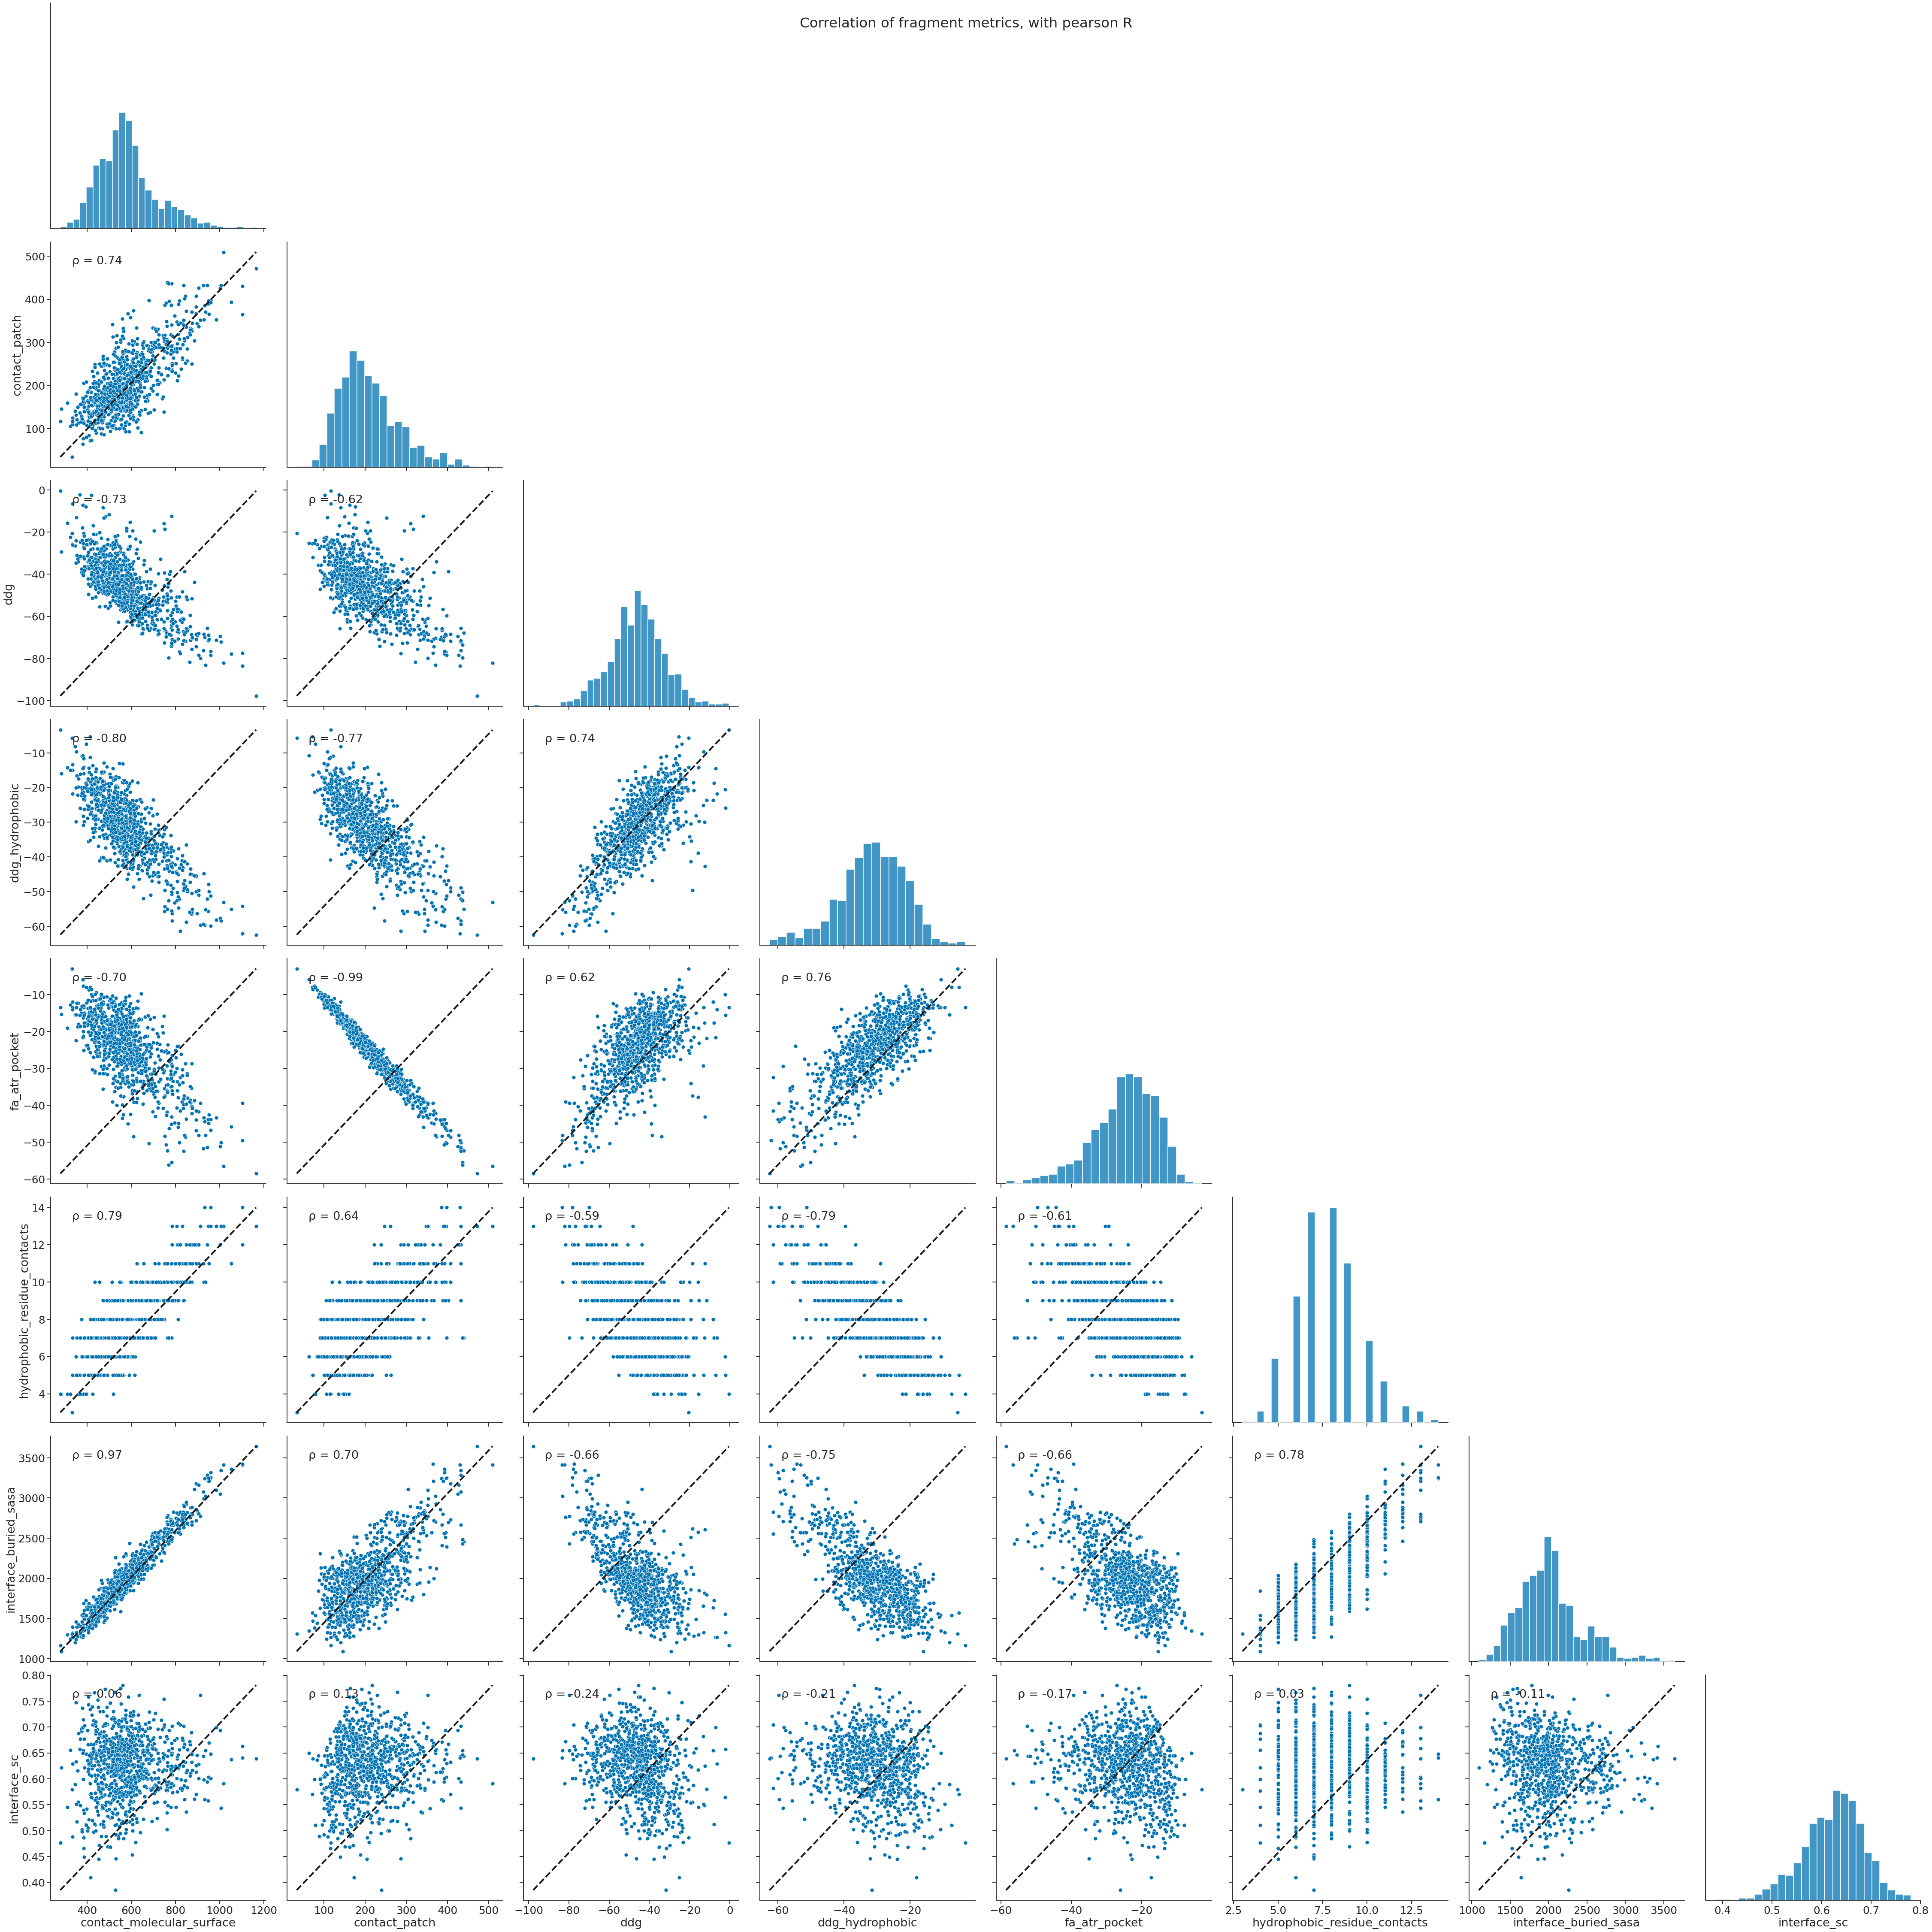

In [6]:
sns.set(
    context="talk",
    font_scale=1.5,  # make the font larger; default is pretty small
    style="ticks",  # make the background white with black lines
    palette="colorblind",  # a color palette that is colorblind friendly!
)


def rho(x, y, ax=None, **kwargs):
    """Plot the correlation coefficient in the top left hand corner of a plot.
    https://stackoverflow.com/questions/50832204/show-correlation-values-in-pairplot-using-seaborn-in-python/50835066
    """
    import scipy

    r, _ = scipy.stats.pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = "\u03C1"
    ax.annotate(f"{rho} = {r:.2f}", xy=(0.1, 0.9), xycoords=ax.transAxes)


def plot_unity(xdata, ydata, **kwargs):
    """https://stackoverflow.com/questions/48122019/how-can-i-plot-identity-lines-on-a-seaborn-pairplot"""
    xmin, ymin = (xdata.min(), ydata.min())
    xmax, ymax = (xdata.max(), ydata.max())
    xpoints = np.linspace(xmin, xmax, 100)
    ypoints = np.linspace(ymin, ymax, 100)
    plt.gca().plot(
        xpoints, ypoints, color="k", marker=None, linestyle="--", linewidth=4.0
    )


subset = scores_df[scores_df["ddg"] < 0]
subset = subset[subset["ddg_hydrophobic"] < 0]

subset = subset[
    [
        "contact_molecular_surface",
        "contact_patch",
        "ddg",
        "ddg_hydrophobic",
        "dslf_fa13",
        "fa_atr_pocket",
        "hydrophobic_residue_contacts",
        "interface_buried_sasa",
        "interface_sc",
        "score_per_res",
        "ss_sc",
        "vbuns5.0_heavy_ball_1.1D",
        "parent",
        "state",
        "target_name",
    ]
]

pack_subset = subset[
    [
        "contact_molecular_surface",
        "contact_patch",
        "ddg",
        "ddg_hydrophobic",
        "fa_atr_pocket",
        "hydrophobic_residue_contacts",
        "interface_buried_sasa",
        "interface_sc",
        "parent",
        "state",
        "target_name",
    ]
]

ax = sns.pairplot(
    data=pack_subset.sample(frac=0.01), hue="parent", corner=True, height=8
)
plt.suptitle("Correlation of interface metrics, split by parent")
sns.despine()
plt.savefig("figs/01_correlations_int_split_by_parent.png")

plt.close()

ax = sns.pairplot(data=pack_subset.sample(frac=0.01), corner=True, height=8)
ax.map_lower(rho)
ax.map_offdiag(plot_unity)
plt.suptitle("Correlation of fragment metrics, with pearson R")
sns.despine()
plt.savefig("figs/01_correlations_int_pearson.png")

In [8]:
d_high = scores_df[scores_df["ddg"] < -40]
d_high = d_high[d_high["interface_buried_sasa"] > 1400]
d_high = d_high[d_high["vbuns5.0_heavy_ball_1.1D"] < 1]
d_high = d_high[d_high["score_per_res"] < -3]
# d_high = d_high[d_high["wnm_all_X"] < 0.8]
# d_high = d_high[d_high["wnm_all_Y"] < 0.8]

print(len(set(d_high.state.values)))
print(len(d_high))
print(len(set(d_high.parent.values)))
set(scores_df.parent.values) - set(d_high.parent.values)

266
26014
57


set()

In [9]:
short = d_high[d_high["chB_start"] < 167]
print(len(short))
print(set(short.parent.values))

3107
{'DHR21', 'DHR07_nocys', 'hDHR49_5CWJ', 'hDHR14_5CWH', 'hDHR14_5H7C', 'DHR39'}


### Setup dask, set command line options, make tasks and submit to client again to test design
I want to see if there's sequence convergence at nstruct 1000 for a random input

In [ ]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
from glob import glob
import logging
import pwd
from pyrosetta.distributed.cluster.core import PyRosettaCluster


print("run the following from your local terminal:")
print(
    f"ssh -L 8000:localhost:8787 {pwd.getpwuid(os.getuid()).pw_name}@{socket.gethostname()}"
)


logging.basicConfig(level=logging.INFO)

options = {
    "-out:level": "300",
    "-holes:dalphaball": "/home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc",
    "-indexed_structure_store:fragment_store": "/net/databases/VALL_clustered/connect_chains/ss_grouped_vall_helix_shortLoop.h5",
    #     "-extra_res_fa": "",
    #     "-extra_res_cen": "",
}
tasks = {"options": "-corrections::beta_nov16 true"}
tasks["extra_options"] = options
tasks[
    "-s"
] = "/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/00_thread_targets/decoys/0000/2021.07.12.10.35.38.485279_00431f82398d4a56b6d2e29532614d17.pdb.bz2"

output_path = os.path.join(os.getcwd(), "01_test_500")


# TODO
flags = """
-out:level 300
-corrections::beta_nov16 true
-holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc
-indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5
-run:constant_seed 1
"""
pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
# TODO
print([base_residue_type.name3() for base_residue_type in pyrosetta.Pose().conformation().modifiable_residue_type_set_for_conf().base_residue_types()])

if __name__ == "__main__":
    # configure SLURM cluster as a context manager
    with SLURMCluster(
        cores=1,
        processes=1,
        job_cpu=1,
        memory="4GB",
        queue="long",
        walltime="2:59:00",
        death_timeout=120,
        local_directory="$TMPDIR/dask",
        log_directory="/mnt/home/pleung/logs/slurm_logs",
        extra=["--lifetime", "3h", "--lifetime-stagger", "4m"],
    ) as cluster:
        print(cluster.job_script())
        # scale between 1-510 workers,
        cluster.adapt(
            minimum=1,
            maximum=510,
            wait_count=400,  # Number of consecutive times that a worker should be suggested for removal it is removed
            interval="5s",  # Time between checks
        )
        # setup a client to interact with the cluster as a context manager
        with Client(cluster) as client:
            print(client)
            PyRosettaCluster(
                tasks=tasks,
                client=client,
                scratch_dir=output_path,
                output_path=output_path,
                nstruct=10,
#                 sha1=None,
#                 dry_run=True,
            ).distribute(protocols=[almost_intdes])

### Unused blocks

In [ ]:
%%time
import pyrosetta
from pyrosetta.distributed import cluster
import pyrosetta.distributed.io as io

flags = """
-out:level 300
-corrections::beta_nov16 true
-holes:dalphaball /home/bcov/ppi/tutorial_build/main/source/external/DAlpahBall/DAlphaBall.gcc
-indexed_structure_store:fragment_store /home/bcov/sc/scaffold_comparison/data/ss_grouped_vall_all.h5
"""
pyrosetta.distributed.init(" ".join(flags.replace("\n\t", " ").split()))
t = almost_intdes(
    None,
    **{
        "-s": "/mnt/home/pleung/projects/peptide_binders/r0/peptide_binders/00_thread_targets/decoys/0000/2021.07.12.10.35.38.485279_00431f82398d4a56b6d2e29532614d17.pdb.bz2",
        "sasa_threshold": 0
    }
)

In [7]:
t.pose.dump_pdb("test.pdb")

True